<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

## Prepare Environment

Jupyter notebook housekeeping

In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline


### Install local canswim package

In [2]:
# pip install -r requirements.txt
# !pip install -e ./

import sys
!{sys.executable} -m pip install -e ./


Obtaining file:///home/ivelin/canswim
  Preparing metadata (setup.py) ... done
  Attempting uninstall: canswim
    Found existing installation: canswim 0.0.1
    Uninstalling canswim-0.0.1:
      Successfully uninstalled canswim-0.0.1
  Running setup.py develop for canswim


## Prepare Model

In [3]:
from canswim.model import CanswimModel

canswim_model = CanswimModel()

canswim_model.load_data()


n_test_range_days: 630
min_samples: 1890
n_stocks:  50
n_epochs:  20
Configuring CUDA GPU
earnings_loaded_df.columns Index(['symbol', 'date', 'eps', 'epsEstimated', 'time', 'revenue',
       'revenueEstimated', 'updatedFromDate', 'fiscalDateEnding'],
      dtype='object')


In [4]:
# canswim_model.covariates.load_past_covariates()
# canswim_model.covariates.load_future_covariates()

In [5]:

def prepare_data():
    canswim_model.prepare_data()
    canswim_model.plot_splits()
    canswim_model.plot_seasonality()



n_stocks:  3
n_epochs:  3
Training loop stock subset: ['META', 'DX', 'PKG']
Preparing ticker series for 3 stocks.
Ticker series dict created.
Filled missing values in ticker series.
Aligned ticker series dict with train start date.
Ticker series prepared.
Single target column selected: Close
Preparing univariate target series: Close
Added holidays to ticker series.
Removing time series for tickers with incomplete data sets: set(). Keeping {'PKG', 'DX', 'META'} 
Preparing train, val, test splits
preparing train, val split for PKG
PKG target start time, end time: 2001-01-01 00:00:00, 2024-01-22 00:00:00
PKG train start time, end time: 2001-01-01 00:00:00, 2019-03-22 00:00:00
PKG val start time, end time: 2019-03-25 00:00:00, 2021-08-20 00:00:00
PKG test start time, end time: 2021-08-23 00:00:00, 2024-01-22 00:00:00
PKG past covs start time, end time: 2000-01-28 00:00:00, 2024-01-22 00:00:00
PKG future covs start time, end time: 2001-01-01 00:00:00, 2024-01-22 00:00:00
preparing train, va

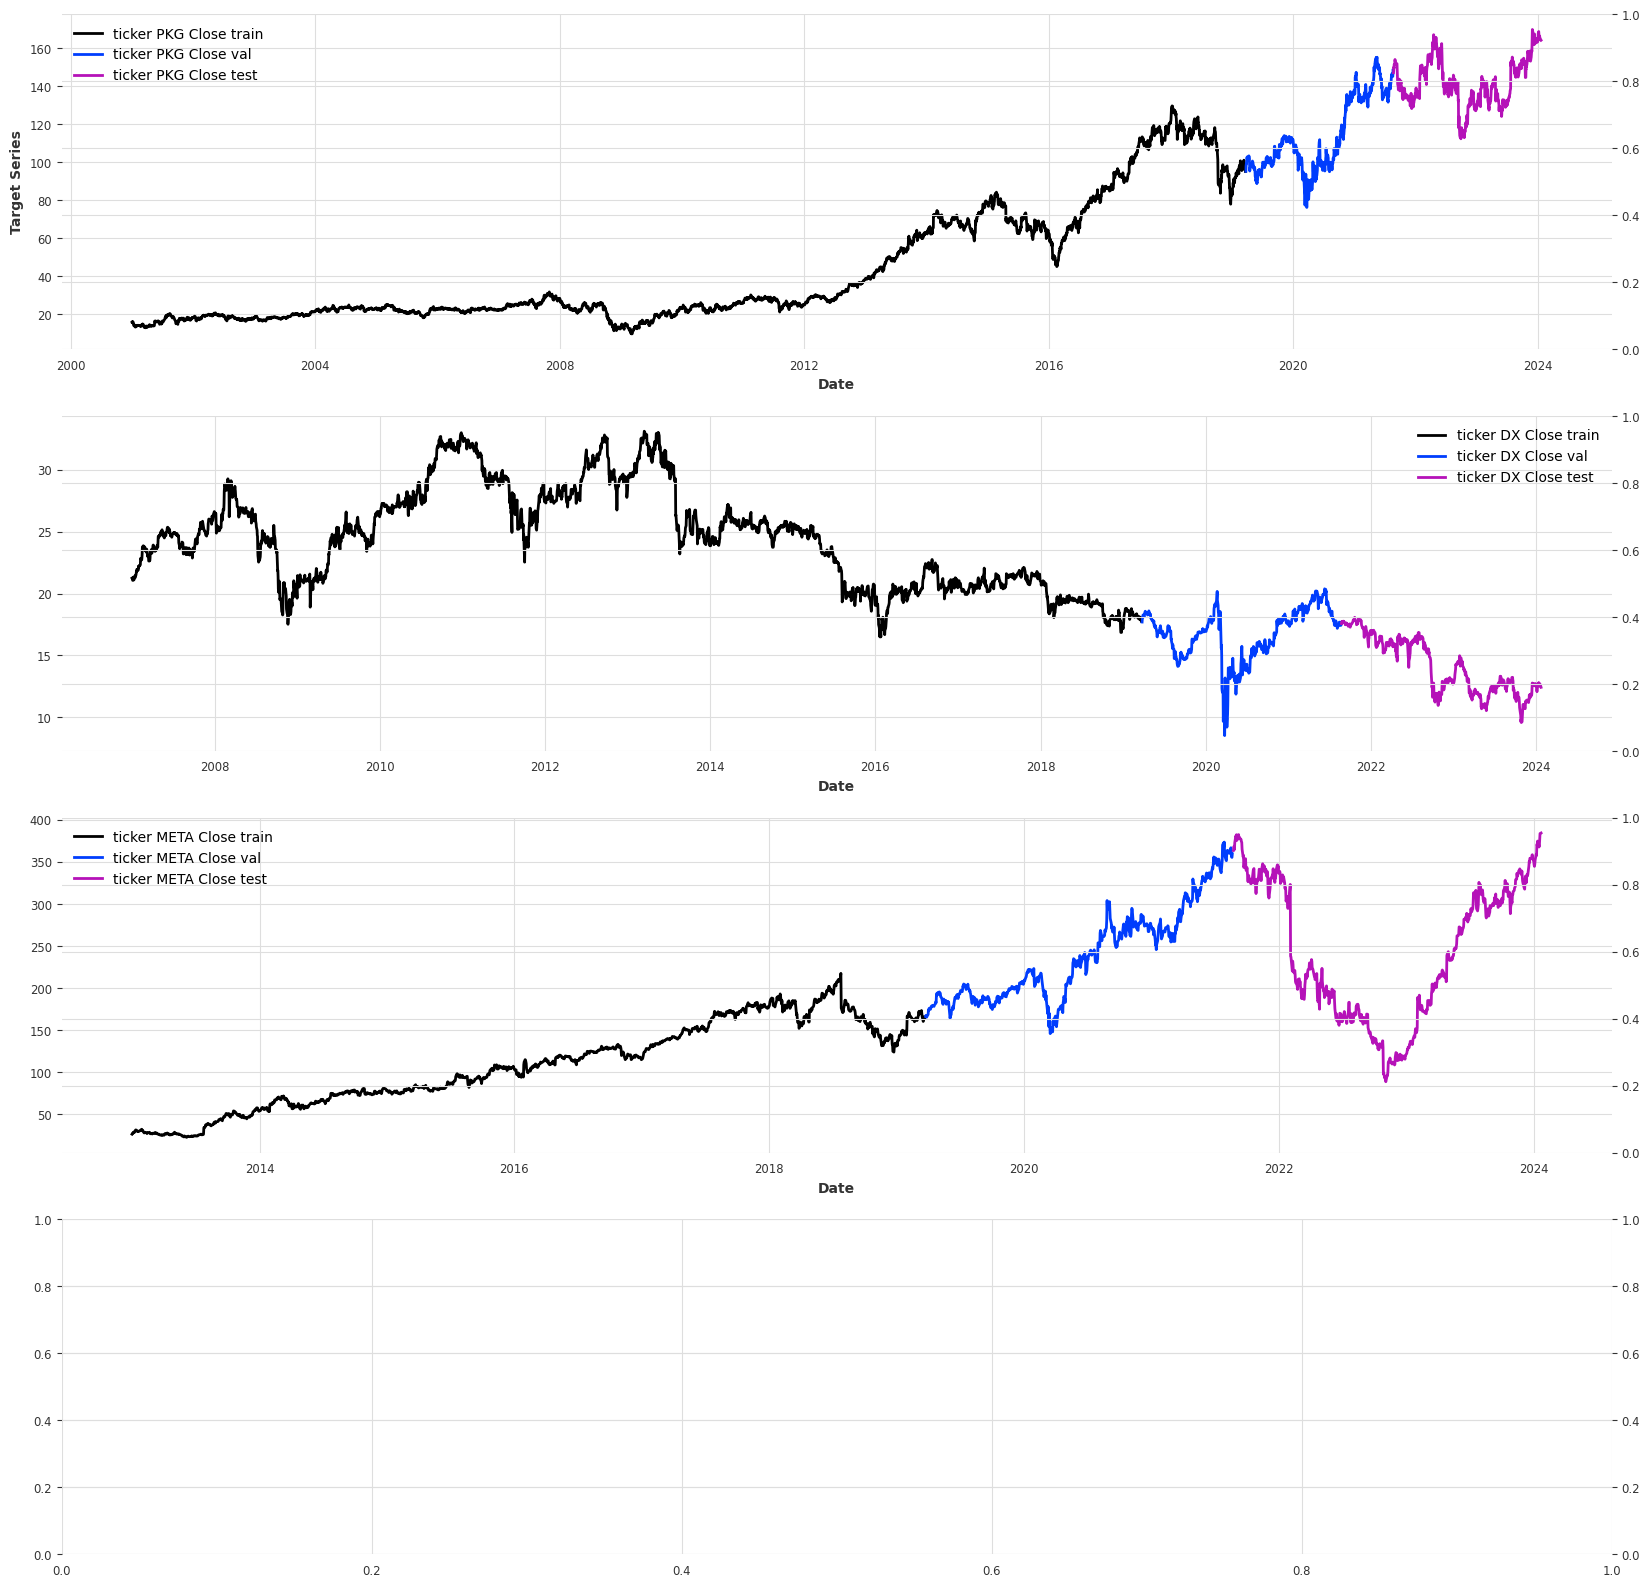

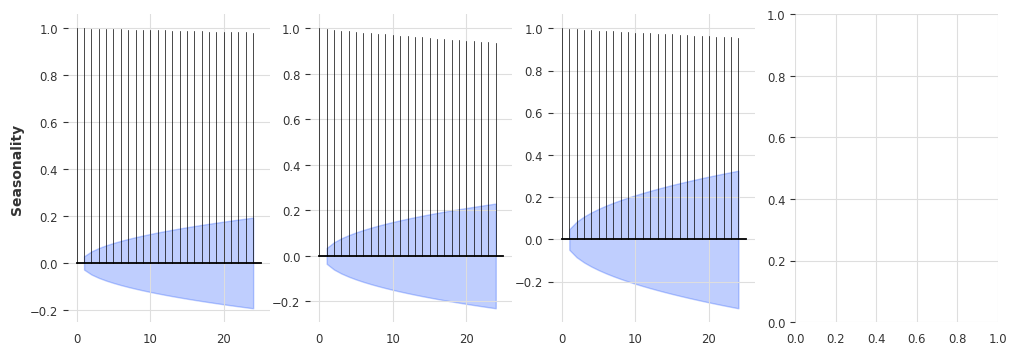

In [26]:
prepare_data()

In [27]:
canswim_model.stock_tickers

['META', 'DX', 'PKG']

In [28]:
t = list(canswim_model.targets.target_series.keys())[0]
t

'PKG'

In [29]:
canswim_model.target_train_list[0].pd_dataframe()

component,Close
Date,
2007-01-01,21.240000
2007-01-02,21.210000
2007-01-03,21.180000
2007-01-04,21.059999
2007-01-05,21.120001
...,...
2019-03-18,18.090000
2019-03-19,18.000000
2019-03-20,17.969999


In [30]:
future_covs = canswim_model.future_cov_list[0].pd_dataframe().tail(500)
past_covs = canswim_model.future_cov_list[0].pd_dataframe().tail(500)

In [31]:
len(canswim_model.targets_list)

3

In [32]:
len(canswim_model.target_train_list)

3

In [33]:
len(canswim_model.past_cov_list)

3

In [34]:
len(canswim_model.future_cov_list)

3

## Find optimal hyper parameters

In [35]:
canswim_model.find_model()


[I 2024-01-27 09:41:12,367] A new study created in memory with name: no-name-2c4ea67d-55ae-47c0-8932-b5f4d1548c28


Creating a new model


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 37.4 K
5 | future_cov_projection | _ResidualBlock   | 40.6 K
6 | encoders              | Sequential       | 2.2 M 
7 | decoders              | Sequential       | 2.7 M 
8 | temporal_decoder      | _ResidualBlock   | 6.8 K 
9 | lookback_skip         | Linear           | 117 K 
-----------------------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.331    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 44.425


In [ ]:
# if a model has not been selected and saved yet
# run a hyper parameter search
# otherwise load saved model and continue training
if not canswim_model.load_model():
    # look for an optimal model configuration
    if canswim_model.find_model():
        # if one is found, save it for further training
        canswim_model.save_model()

## Train model

### Run model training loop

In [ ]:

# train loop
for i in range(10):
    # align all data series for training
    canswim_model.train()
    # save model checkpoint
    canswim_model.save()
    # quick test progress at modelcheckpoing
    canswim_model.test()
    canswim_model.plot_test_results()    
    # thorough backtest of model checkpoint
    backtest, test_error = canswim_model.backtest()        
    print(f"Backtest Quantile Loss = {test_error}")
    canswim_model.plot_backtest_results(backtest)    
    # prepare next sample subset
    prepare_data()
